In [13]:
!pip install pandas numpy seaborn matplotlib scikit-learn xgboost lightgbm imbalanced-learn scipy

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 24, Finished, Available, Finished)


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.



In [14]:
import pandas as pd 
import numpy as np
import datetime as dt 
import seaborn as sns 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 26, Finished, Available, Finished)

In [15]:
df = spark.sql("""
SELECT 
    f.TransactionDate,
    f.SalesAmount,
    f.CustomerID
FROM FabricStaging.fact_sales f
""").toPandas()
df.head()

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 27, Finished, Available, Finished)

,TransactionDate,SalesAmount,CustomerID
0,2022-01-17 00:00:00+00:00,277948,807144
1,2022-01-17 00:00:00+00:00,524281,1341545
2,2022-01-17 00:00:00+00:00,273796,1985092
3,2022-01-17 00:00:00+00:00,104860,565430
4,2022-01-17 00:00:00+00:00,195694,1582466


In [16]:
df2 =df 
df2.info()

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 28, Finished, Available, Finished)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   TransactionDate  1048575 non-null  object
 1   SalesAmount      1048575 non-null  int64 
 2   CustomerID       1048575 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [17]:
df2['TransactionDate'] = pd.to_datetime(df2['TransactionDate'], errors='coerce')
df2['Year'] = df2['TransactionDate'].dt.year
df2['Month'] = df2['TransactionDate'].dt.month
df2['Quarter'] = df2['TransactionDate'].dt.quarter
df2['DayOfWeek'] = df2['TransactionDate'].dt.day_name()
df2.head()

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 29, Finished, Available, Finished)

,TransactionDate,SalesAmount,CustomerID,Year,Month,Quarter,DayOfWeek
0,2022-01-17 00:00:00+00:00,277948,807144,2022,1,1,Monday
1,2022-01-17 00:00:00+00:00,524281,1341545,2022,1,1,Monday
2,2022-01-17 00:00:00+00:00,273796,1985092,2022,1,1,Monday
3,2022-01-17 00:00:00+00:00,104860,565430,2022,1,1,Monday
4,2022-01-17 00:00:00+00:00,195694,1582466,2022,1,1,Monday


In [19]:
# --- 1️⃣ Lọc dữ liệu năm 2023 từ df2 (cú pháp giống df_train) ---
df3 = df2[(df2['Year'] == 2023)].loc[:, ['CustomerID', 'SalesAmount', 'TransactionDate']].copy()
# --- 2️⃣ Lấy ngày giao dịch cuối cùng của từng khách hàng ---
df3['LastOrder'] = df3.groupby('CustomerID')['TransactionDate'].transform('max')
# --- 3️⃣ Chuẩn hóa kiểu dữ liệu thời gian ---
df3['TransactionDate'] = pd.to_datetime(df3['TransactionDate']).dt.tz_localize(None)
df3['LastOrder'] = pd.to_datetime(df3['LastOrder']).dt.tz_localize(None)
# --- 4️⃣ Tạo ngày báo cáo cố định ---
df3['ReportDate'] = pd.to_datetime('2023-01-10')
# --- 5️⃣ Tính các chỉ số RFM ---
df3['Recency'] = (df3['ReportDate'] - df3['LastOrder']).dt.days
df3['Frequency'] = df3.groupby('CustomerID')['TransactionDate'].transform('count')
df3['Monetary'] = df3.groupby('CustomerID')['SalesAmount'].transform('sum')
# --- 6️⃣ Giữ lại một dòng duy nhất cho mỗi khách hàng ---
df3 = df3.drop_duplicates(subset='CustomerID').reset_index(drop=True)
# --- 7️⃣ Kiểm tra kết quả ---
print("✅ Dữ liệu sau tính toán:", df3.shape)
df3.head()


StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 31, Finished, Available, Finished)

✅ Dữ liệu sau tính toán: (18644, 8)


,CustomerID,SalesAmount,TransactionDate,LastOrder,ReportDate,Recency,Frequency,Monetary
0,1452379,375012,2023-01-01,2023-01-01,2023-01-10,9,1,375012
1,526953,493194,2023-01-01,2023-01-01,2023-01-10,9,1,493194
2,1033262,81748,2023-01-01,2023-01-01,2023-01-10,9,1,81748
3,106225,292970,2023-01-01,2023-01-01,2023-01-10,9,1,292970
4,212809,528095,2023-01-01,2023-01-01,2023-01-10,9,1,528095


StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 32, Finished, Available, Finished)

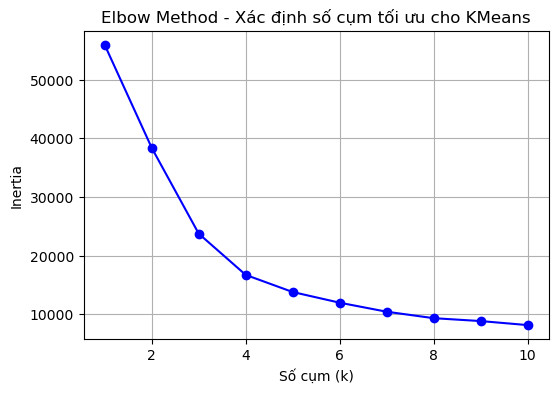

In [20]:
# --- 1️⃣ Chuẩn hóa dữ liệu cho KMeans ---
rfm_features = df3[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
# --- Tham số KMeans cố định ---
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}
# --- Chạy Elbow Method ---
inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(rfm_scaled)   # rfm_scaled là dữ liệu chuẩn hóa ['Recency', 'Frequency', 'Monetary']
    inertia.append(kmeans.inertia_)
# --- Vẽ biểu đồ Elbow ---
plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Số cụm (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method - Xác định số cụm tối ưu cho KMeans')
plt.grid(True)
plt.show()

In [21]:
kmeans = KMeans(n_clusters=4, **kmeans_kwargs)
kmeans.fit(rfm_scaled)
cluster_labels = kmeans.labels_
centroid = kmeans.cluster_centers_
# --- Gán nhãn cụm vào df3 ---
df3['Cluster'] = kmeans.labels_
df3

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 33, Finished, Available, Finished)

,CustomerID,SalesAmount,TransactionDate,LastOrder,ReportDate,Recency,Frequency,Monetary,Cluster
0,1452379,375012,2023-01-01,2023-01-01,2023-01-10,9,1,375012,0
1,526953,493194,2023-01-01,2023-01-01,2023-01-10,9,1,493194,0
2,1033262,81748,2023-01-01,2023-01-01,2023-01-10,9,1,81748,0
3,106225,292970,2023-01-01,2023-01-01,2023-01-10,9,1,292970,0
4,212809,528095,2023-01-01,2023-01-01,2023-01-10,9,1,528095,0
...,...,...,...,...,...,...,...,...,...
18639,1398136,178107,2023-01-09,2023-01-09,2023-01-10,1,1,178107,2
18640,2023258,331447,2023-01-09,2023-01-09,2023-01-10,1,1,331447,2
18641,2041510,381509,2023-01-09,2023-01-09,2023-01-10,1,1,381509,2
18642,1927215,508205,2023-01-09,2023-01-09,2023-01-10,1,1,508205,2


StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 34, Finished, Available, Finished)

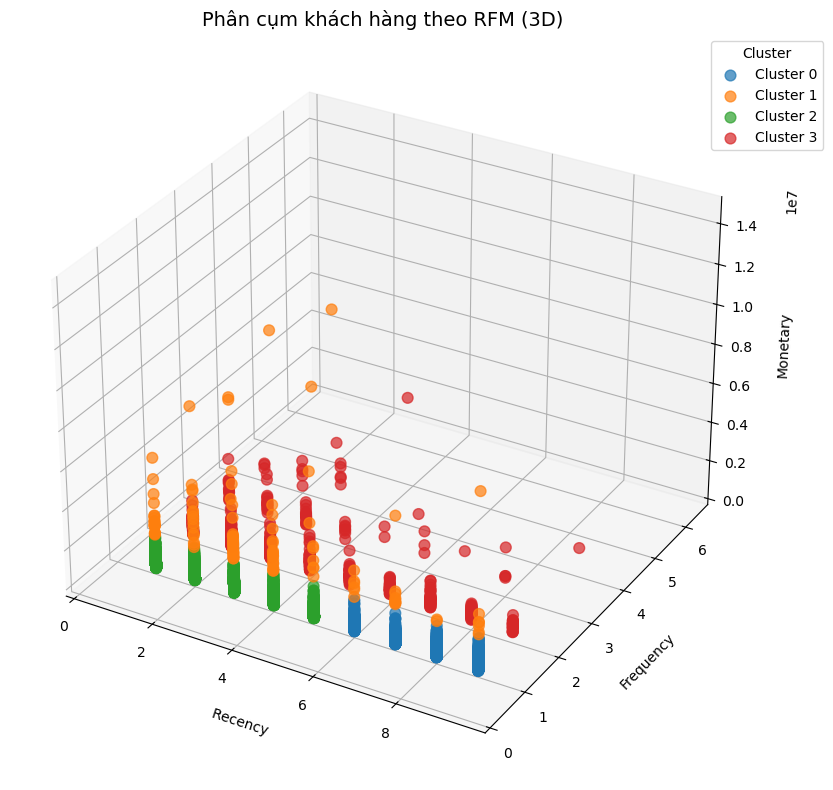

In [22]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# Giả sử df3 là dataframe chứa RFM và nhãn cụm
# 'Cluster' là cột phân cụm, thay cho best_clusters nếu đã gán rồi

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Vẽ từng cụm
for cluster_label in sorted(df3['Cluster'].unique()):
    cluster_data = df3[df3['Cluster'] == cluster_label]
    ax.scatter(
        cluster_data['Recency'],
        cluster_data['Frequency'],
        cluster_data['Monetary'],
        s=60,
        alpha=0.7,
        label=f'Cluster {cluster_label}'
    )

# --- Cài đặt giới hạn trục (tuỳ theo dữ liệu thực tế) ---
ax.set_xlim(0, df3['Recency'].max() * 1.1)
ax.set_ylim(0, df3['Frequency'].max() * 1.1)
ax.set_zlim(0, df3['Monetary'].max() * 1.1)

# --- Gắn nhãn & tiêu đề ---
ax.set_xlabel('Recency ', labelpad=10)
ax.set_ylabel('Frequency', labelpad=10)
ax.set_zlabel('Monetary', labelpad=10)
ax.set_title('Phân cụm khách hàng theo RFM (3D)', fontsize=14)

# --- Legend ---
ax.legend(title='Cluster', bbox_to_anchor=(1.1, 1))

plt.tight_layout()
plt.show()


StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 35, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


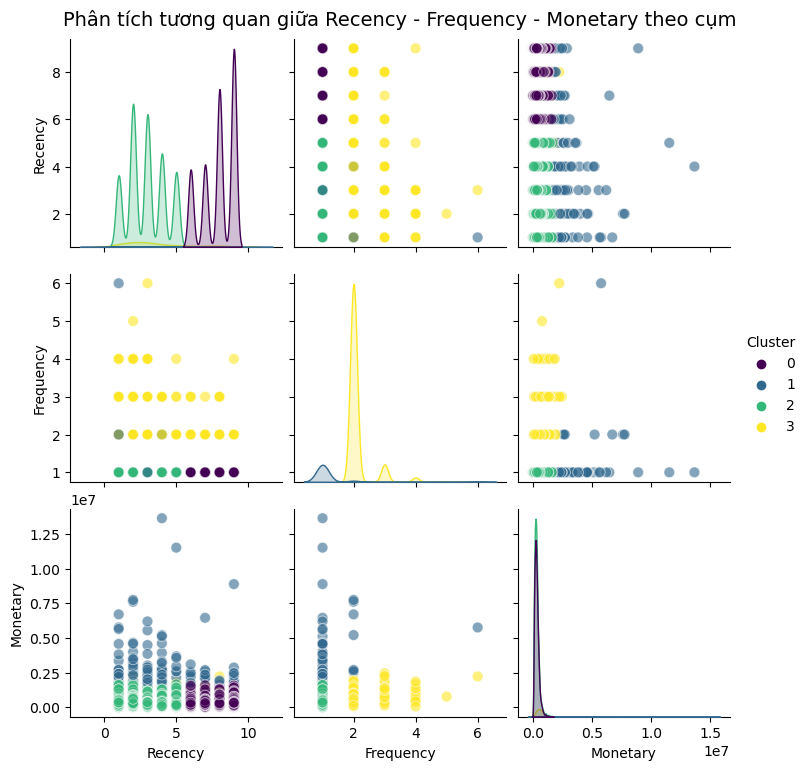

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
# --- Biểu đồ pairplot RFM theo cụm ---
sns.pairplot(
    data=df3,                                    
    vars=['Recency', 'Frequency', 'Monetary'],   
    hue='Cluster',                               
    palette='viridis',                           
    diag_kind='kde',                             
    markers='o',                                 
    plot_kws={'alpha': 0.6, 's': 60}             
)
plt.suptitle("Phân tích tương quan giữa Recency - Frequency - Monetary theo cụm", 
             fontsize=14, y=1.02)
plt.show()

In [24]:
# 🔄 Chuyển pandas DataFrame sang Spark DataFrame
df3_spark = spark.createDataFrame(df3)
# 💾 Lưu vào Lakehouse (bảng Delta)
df3_spark.write.mode("overwrite").format("delta").saveAsTable("RFM_Segmentation_2023")
print("✅ Đã lưu RFM_Segmentation_2023 vào Lakehouse Tables thành công!")

StatementMeta(, 81a57400-ecc5-48e0-b2a5-7b39d9cb75d5, 36, Finished, Available, Finished)

✅ Đã lưu RFM_Segmentation_2023 vào Lakehouse Tables thành công!
